In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:16, 2623.86it/s]



Посмотрим на пример отзыва:

In [3]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [4]:
df_main = pd.DataFrame(responses)

In [5]:
df_main.shape

(153499, 10)

Препроцессинг

In [6]:
import re
from nltk.corpus import stopwords
from tqdm.auto import tqdm
tqdm.pandas()
import pymorphy2
import nltk

m = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vlad2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Анализ текстов

In [7]:
# загрузим стоп-слова
mystopwords = stopwords.words('russian')

# а также отметим слова из кириллицы
ru_words = re.compile("[А-Яа-я]+")

# фльтрация слов, чтобы знаки препинания и числа не учитывались
def words_only(text):
    return " ".join(ru_words.findall(text))

# леммы
def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "

# удаление стоп слов
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

# далее несколько функций для обработки текста
def preprocess_lem_rm(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

def preprocess_rm(text):
    return remove_stopwords(words_only(text.lower()))

def preprocess(text):
    return words_only(text.lower())

In [8]:
# общее число строк 153499
num_rows = 50000

# выделим часть для более быстрой обработки
df = df_main.head(num_rows)

проведем обработку, в которой оставим только слова

In [9]:
df.text = df.text.astype('str').progress_apply(preprocess)

  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\vlad2\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Число отзывов по городам:

In [10]:
df_city = df['city'].value_counts().reset_index()
df_city

,index,city
0,г. Москва,20764
1,г. Санкт-Петербург,5339
2,г. Екатеринбург,900
3,г. Новосибирск,832
4,г. Нижний Новгород,785
...,...,...
1951,г. екатеринбург (Россия),1
1952,г. Приозерск (Санкт-Петербург),1
1953,г. Кинешма Ивановской области,1
1954,г. Тбилиси (Москва),1


#### Число отзывов по банкам:

In [11]:
df_bank = df['bank_name'].value_counts().reset_index()
df_bank

,index,bank_name
0,Сбербанк России,7880
1,Альфа-Банк,3388
2,Хоум Кредит Банк,2861
3,Русский Стандарт,2466
4,ВТБ 24,2461
...,...,...
403,Энергобанк,1
404,Бумеранг,1
405,Ставропольпромстройбанк,1
406,Дойче Банк,1


#### 10 самых частых слов

токенизируем слова

In [12]:
allWords = df['text'].apply(nltk.tokenize.word_tokenize)
flat_list = [item for sublist in allWords for item in sublist]
allWordDist = nltk.FreqDist(w.lower() for w in flat_list)

сделаем dataframe с самыми популярными словами

In [13]:
df_fdist = pd.DataFrame.from_dict(allWordDist, orient='index')
df_fdist = df_fdist.sort_values(by=[0], ascending=False)
df_fdist = df_fdist.rename_axis(['word']).reset_index()
df_fdist.head(10)

,word,0
0,в,398161
1,и,316577
2,не,260356
3,на,214955
4,что,189784
5,я,174484
6,с,144831
7,по,116006
8,мне,97007
9,банка,89230


#### 10 самых частых слов без стоп слов

Запустим предобработку удаляющую стоп слова, после чего тоекинизируем их

In [14]:
df_rm = df_main.head(num_rows)
df_rm.text = df_rm.text.astype('str').progress_apply(preprocess_rm)
allWords_rm = df_rm['text'].apply(nltk.tokenize.word_tokenize)
flat_list_rm = [item for sublist in allWords_rm for item in sublist]
allWordDist_rm = nltk.FreqDist(w.lower() for w in flat_list_rm)

  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\vlad2\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


dataframe слов без стоп слов

In [15]:
df_fdist = pd.DataFrame.from_dict(allWordDist_rm, orient='index')
df_fdist = df_fdist.sort_values(by=[0], ascending=False)
df_fdist_rm = df_fdist.rename_axis(['word']).reset_index()
df_fdist_rm.head(10)

,word,0
0,банка,89230
1,банк,69078
2,это,52854
3,деньги,37766
4,карты,28960
5,карту,28263
6,т,27160
7,день,25229
8,кредит,24633
9,г,22577


#### 10 самых частых лемм

выполним предобработку, удаляющую стоп слова и приводящую все к леммам

In [16]:
df_lem_rm = df_main.head(num_rows)
df_lem_rm.text = df_lem_rm.text.astype('str').progress_apply(preprocess_lem_rm)
allWords_lem_rm = df_lem_rm['text'].apply(nltk.tokenize.word_tokenize)
flat_list_lem_rm = [item for sublist in allWords_lem_rm for item in sublist]
allWordDist_lem_rm = nltk.FreqDist(w.lower() for w in flat_list_lem_rm)

  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\vlad2\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


dataframe лемм

In [17]:
df_fdist = pd.DataFrame.from_dict(allWordDist_lem_rm, orient='index')
df_fdist = df_fdist.sort_values(by=[0], ascending=False)
df_fdist_lem_rm = df_fdist.rename_axis(['word']).reset_index()
df_fdist_lem_rm.head(10)

,word,0
0,банк,212536
1,карта,92436
2,это,57787
3,день,53399
4,деньга,51263
5,кредит,49345
6,который,46884
7,сотрудник,46697
8,клиент,41745
9,отделение,40507


#### Закон Ципфа
Если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n.

из dataframe с леммами построим кривую ципфа

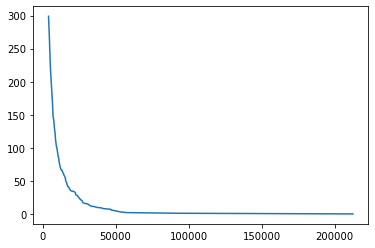

In [18]:
freqs = list(df_fdist_lem_rm[0])

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

#### Закон Хипса

С увеличением длины текста, количество слов увеличивается в соответствии с законом: $|V| = K*N^b$

$N$  –  число токенов, $|V|$  – количество слов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$кривая Хипса

используя counter пройдемся по строкам, каждый раз подсчитывая общее число токенов

In [19]:
from collections import Counter
from string import punctuation

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df_lem_rm.iterrows(), total = len(df)):
    tokens = nltk.tokenize.word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values()))) # странная ошибка при sum(cnt.values)

  0%|          | 0/50000 [00:00<?, ?it/s]

подробнее об ошибке выше, связанной с тем, что .values() выдает dict_values([]), а не просто список
https://stackoverflow.com/questions/69048057/summing-dict-values-in-python-3-not-working-as-it-should

построим по полученным данным график

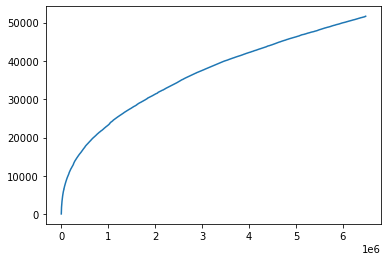

In [20]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

в последующих 2 вопросах мы просто смотрим число лемм в соответствующем dataframe

#### какое слово встречается чаще, "сотрудник" или "клиент"?

In [21]:
df_fdist_lem_rm.loc[df_fdist_lem_rm['word'] == 'сотрудник']

,word,0
7,сотрудник,46697


In [22]:
df_fdist_lem_rm.loc[df_fdist_lem_rm['word'] == 'клиент']

,word,0
8,клиент,41745


#### сколько раз встречаются слова "мошенничество" и "доверие"?

In [23]:
df_fdist_lem_rm.loc[df_fdist_lem_rm['word'] == 'мошенничество']

,word,0
1027,мошенничество,1062


In [24]:
df_fdist_lem_rm.loc[df_fdist_lem_rm['word'] == 'доверие']

,word,0
1473,доверие,661


#### 1-граммы

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

для исследования связи с оценкой мы отсортируем dataframe (c стопсловами), чтобы не учитывать отзывы без оценок

In [26]:
filtered_df = df[df[['text', 'rating_grade']].notnull().all(1)]
filtered_df = filtered_df[['text', 'rating_grade']]
filtered_df

,text,rating_grade
14,также многие давний клиент банк довольный высо...,2.0
19,открыть вклад счёт плюс зарплатный карта рубль...,1.0
33,добрый время вчера поступить смс уведомление б...,1.0
76,г около час прийти указанный офис намерение по...,1.0
85,оплата коммунальный платёж пользоваться пласти...,1.0
...,...,...
49995,ооо мегуметь оао сбербанк россия заключить дог...,1.0
49996,добрый день славный банк карта мтс деньга раск...,1.0
49997,работать интернет банк сайт недоступный целое ...,3.0
49998,резюме отобрать деньга неопредел нный срок бан...,2.0


посмотрим сколько раз встречается каждая из оценок

In [27]:
filtered_df['rating_grade'].value_counts()

1.0    13526
2.0     3788
5.0     2607
3.0     1951
4.0      706
Name: rating_grade, dtype: int64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(filtered_df.text, filtered_df.rating_grade)

In [29]:
print(filtered_df.shape)
print(x_train.shape)
print(x_test.shape)

(22578, 2)
(16933,)
(5645,)


In [30]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

In [31]:
list(vec.vocabulary_.items())[:20]

[('первый', 19618),
 ('обратиться', 17267),
 ('связь', 27037),
 ('банк', 1225),
 ('хотеть', 32688),
 ('оформить', 19176),
 ('потребительский', 22439),
 ('кредит', 11596),
 ('предоставить', 22819),
 ('нужный', 16853),
 ('док', 6507),
 ('почему', 22553),
 ('отказать', 18637),
 ('день', 5997),
 ('ответ', 18517),
 ('приехать', 23278),
 ('офис', 19160),
 ('забрать', 7624),
 ('отдавать', 18576),
 ('ссылаться', 28900)]

In [32]:
from nltk import ngrams

In [33]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [34]:
from sklearn.metrics import classification_report

pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.81      0.73      0.76      3775
         2.0       0.22      0.25      0.23       823
         3.0       0.12      0.20      0.15       307
         4.0       0.11      0.29      0.16        73
         5.0       0.81      0.76      0.78       667

    accuracy                           0.63      5645
   macro avg       0.41      0.44      0.42      5645
weighted avg       0.67      0.63      0.65      5645



#### Биграммы

аналогично 1-граммам, просто заменяем $(1,1)$ на $(2,2)$

In [35]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\vlad2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         1.0       0.95      0.68      0.79      4791
         2.0       0.06      0.24      0.10       245
         3.0       0.01      0.15      0.03        46
         4.0       0.01      0.29      0.02         7
         5.0       0.70      0.80      0.75       556

    accuracy                           0.66      5645
   macro avg       0.35      0.43      0.34      5645
weighted avg       0.88      0.66      0.75      5645



#### TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.68      0.81      4895
         2.0       0.02      0.25      0.04        79
         3.0       0.02      0.44      0.03        18
         4.0       0.01      1.00      0.01         1
         5.0       0.82      0.79      0.80       652

    accuracy                           0.69      5645
   macro avg       0.37      0.63      0.34      5645
weighted avg       0.95      0.69      0.79      5645



## Тематическое моделирование

In [38]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

Рассмотрим отзывы на 30 самых популярных (по отзывам) банков

для этого возьмем список банков из dataframe с числом их упоминания

In [39]:
df_bank_selected = df_bank.head(30)
bank_list = df_bank_selected['index'].to_list()

после чего отсортируем изначальный dataframe, оставив только эти банки и возьмем какой-нибудь sample

In [40]:
filtered_df = df_main[df_main['bank_name'].isin(bank_list)]
filtered_df = filtered_df.sample(2500)
filtered_df['bank_name'].value_counts()

Сбербанк России                   577
Альфа-Банк                        208
Русский Стандарт                  175
Хоум Кредит Банк                  166
ВТБ 24                            151
Национальный Банк «Траст»         107
Тинькофф Банк                      99
Ренессанс Кредит                   92
Связной Банк                       81
ОТП Банк                           78
Московский Кредитный Банк          67
Восточный Экспресс Банк            67
Ситибанк                           62
Банк Москвы                        58
Райффайзенбанк                     54
ЮниКредит Банк                     52
Авангард                           48
Промсвязьбанк                      46
Киви Банк                          45
МТС Банк                           43
Ханты-Мансийский банк Открытие     39
Росбанк                            37
Бинбанк                            32
Московский Областной Банк          29
Сетелем Банк                       27
АйМаниБанк                         18
Совкомбанк  

далее делаем аналогично лекции

In [41]:
texts = [text.split() for text in filtered_df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [42]:
len(corpus)

2500

In [43]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [44]:
corpus_tfidf

In [45]:
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [46]:
sims.shape

(2500, 2500)

заметим, что матрица близости без снижения размерности на первый взгляд не несет никакой полезной информации

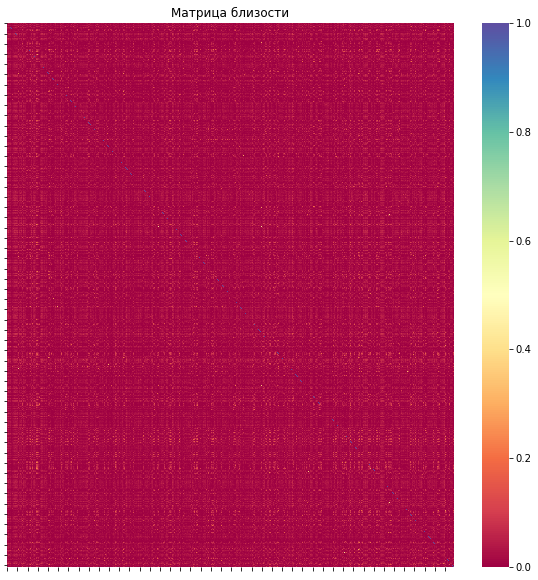

In [47]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Латентно-семантический анализ (LSA, LSI)

In [48]:
from gensim.models import lsimodel

In [49]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=25)

рассмотрим самые популярные темы

In [50]:
lsi.show_topics(10)

[(0,
  '0.209*"в" + 0.185*"и" + 0.160*"не" + 0.150*"карта" + 0.140*"что" + 0.134*"я" + 0.133*"банк" + 0.129*"на" + 0.116*"-" + 0.112*"мне"'),
 (1,
  '-0.187*"карта" + 0.183*"в" + -0.163*"деньга" + 0.162*"и" + -0.158*"банк" + 0.140*"не" + 0.122*"что" + 0.118*"я" + 0.112*"на" + 0.103*"-"'),
 (2,
  '-0.312*"карта" + 0.257*"звонок" + -0.231*"деньга" + 0.230*"ваш" + 0.199*"номер" + 0.194*"кредит" + 0.175*"звонить" + 0.148*"телефон" + -0.141*"сбербанк" + 0.125*"поступать"'),
 (3,
  '0.319*"кредит" + 0.244*"платёж" + 0.236*"страховка" + 0.221*"сумма" + -0.221*"номер" + -0.180*"карта" + -0.150*"ваш" + -0.139*"кошелёк" + 0.139*"погашение" + 0.138*"кредитный"'),
 (4,
  '-0.339*"вклад" + 0.302*"кошелёк" + 0.233*"платёж" + 0.175*"деньга" + 0.136*"киви" + 0.134*"сбербанк" + -0.127*"карта" + 0.123*"служба" + 0.122*"терминал" + 0.117*"средство"'),
 (5,
  '-0.453*"карта" + 0.297*"деньга" + 0.191*"кошелёк" + 0.184*"вклад" + -0.166*"кредитный" + -0.136*"смс" + -0.116*"комиссия" + 0.112*"страховка" + -0.

рассмотрим некоторые в отдельности

In [51]:
lsi.show_topics(3)

[(0,
  '0.209*"в" + 0.185*"и" + 0.160*"не" + 0.150*"карта" + 0.140*"что" + 0.134*"я" + 0.133*"банк" + 0.129*"на" + 0.116*"-" + 0.112*"мне"'),
 (1,
  '-0.187*"карта" + 0.183*"в" + -0.163*"деньга" + 0.162*"и" + -0.158*"банк" + 0.140*"не" + 0.122*"что" + 0.118*"я" + 0.112*"на" + 0.103*"-"'),
 (2,
  '-0.312*"карта" + 0.257*"звонок" + -0.231*"деньга" + 0.230*"ваш" + 0.199*"номер" + 0.194*"кредит" + 0.175*"звонить" + 0.148*"телефон" + -0.141*"сбербанк" + 0.125*"поступать"')]

вероятно, 3 тема связана с телефонной ($+ 0.161 \cdot$"звонить") рекламой кредитов ($+ 0.216 \cdot$"кредит")

также можно заметить, что сбербанк, имеющий наибольшее число отзывов, включен (с + или - коэффициентом) во многие темы

рассмотрим матрицу близости после снижения размерности, заметим, что в этот раз она несет больше информации

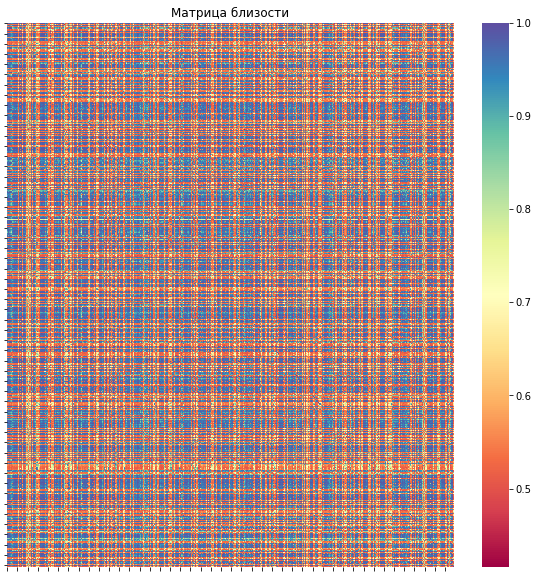

In [52]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

#### Главные компоненты

In [53]:
X = [0] * len(filtered_df)
Y = [0] * len(filtered_df)
for i in range(len(filtered_df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X,
                       'Y': Y,
                       'bank name' : filtered_df.bank_name})

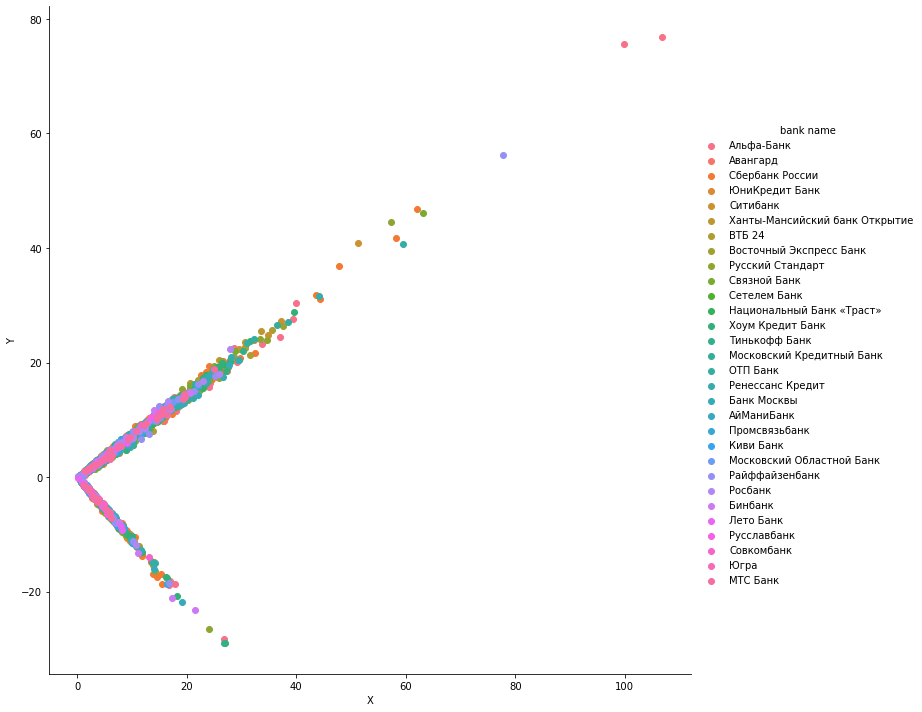

In [54]:
sns.FacetGrid(vis_df, hue="bank name", height = 10).map(plt.scatter, "X", "Y").add_legend()

### Truncated SVD и TSNE

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
vectors = TfidfVectorizer().fit_transform(filtered_df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [57]:
X_reduced

array([[ 5.46666674e-01, -1.07534855e-01,  1.22097201e-02,
        -1.77320793e-02, -1.45241792e-01],
       [ 4.86866010e-02,  8.27241324e-02, -3.33612898e-04,
        -2.68653985e-02, -3.45547644e-02],
       [ 1.40826610e-01, -1.53417712e-02,  3.28402280e-02,
        -2.17626872e-02,  4.12904279e-02],
       ...,
       [ 1.74917544e-01,  3.63722354e-01, -4.31271352e-02,
        -1.29391443e-01,  8.54558732e-02],
       [ 6.81762036e-02, -2.04467173e-03,  7.11986188e-03,
        -1.17516175e-02,  1.63727406e-02],
       [ 7.62636377e-02,  2.14780556e-01, -4.07304908e-02,
         8.42926377e-02,  6.64485555e-02]])

In [58]:
X_embedded = TSNE(n_components=2,
                  perplexity=5,
                  verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

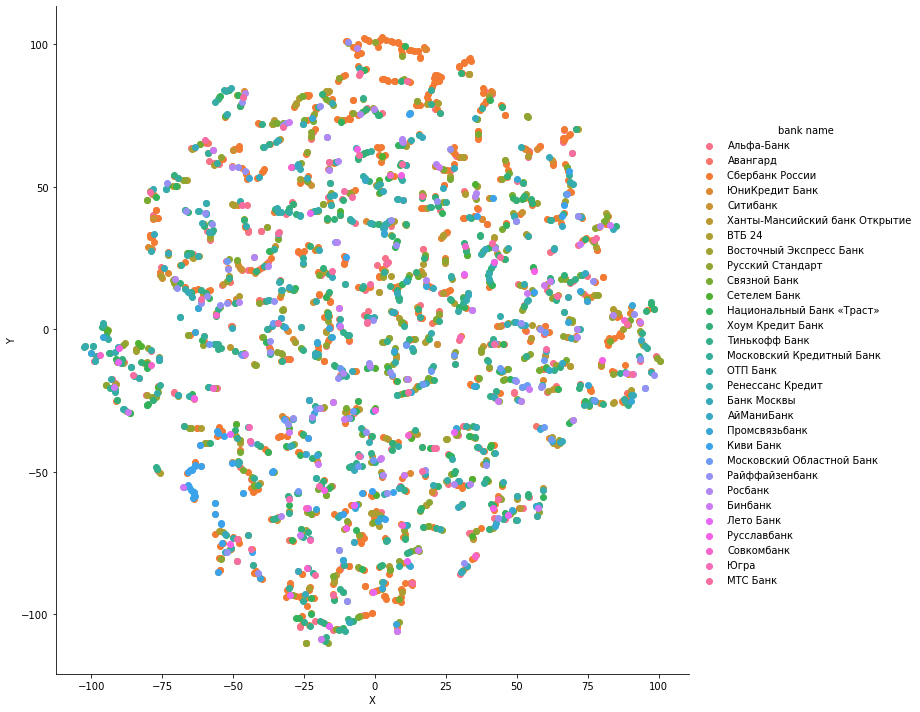

In [59]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0],
                       'Y': X_embedded[:, 1],
                       'bank name' : filtered_df.bank_name})
sns.FacetGrid(vis_df, hue="bank name", height=10).map(plt.scatter, "X", "Y").add_legend()

## Классификация текстов

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [61]:
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

In [62]:
df = df_main.head(50000)

filtered_df = df[df[['text', 'rating_grade']].notnull().all(1)]
filtered_df.drop(filtered_df[(filtered_df.rating_grade < 5)
                             & (filtered_df.rating_grade > 1)].index, 
                 inplace=True)
filtered_df = filtered_df[['text', 'rating_grade']]
filtered_df

C:\Users\vlad2\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,text,rating_grade
19,открыть вклад счёт плюс зарплатный карта рубль...,1.0
33,добрый время вчера поступить смс уведомление б...,1.0
76,г около час прийти указанный офис намерение по...,1.0
85,оплата коммунальный платёж пользоваться пласти...,1.0
94,апрель год прийти отделение сбербанк г чапаевс...,1.0
...,...,...
49990,добрый день уважаемый коллега хотеться отметит...,5.0
49991,апрель год обратиться промтрансбанк адрес гага...,1.0
49993,оформлять кредит телефон исправно платить кред...,1.0
49995,ооо мегуметь оао сбербанк россия заключить дог...,1.0


In [63]:
filtered_df['rating_grade'].value_counts()

1.0    13526
5.0     2607
Name: rating_grade, dtype: int64

In [64]:
x_train, x_test, y_train, y_test = train_test_split(filtered_df.text, filtered_df.rating_grade)

In [65]:
print(filtered_df.shape)
print(x_train.shape)
print(x_test.shape)

(16133, 2)
(12099,)
(4034,)


Униграммы

In [66]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\vlad2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98      3424
         5.0       0.85      0.91      0.88       610

    accuracy                           0.96      4034
   macro avg       0.92      0.94      0.93      4034
weighted avg       0.96      0.96      0.96      4034



Биграммы

In [67]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.93      0.96      3641
         5.0       0.58      0.97      0.73       393

    accuracy                           0.93      4034
   macro avg       0.79      0.95      0.84      4034
weighted avg       0.96      0.93      0.94      4034



Триграммы

In [68]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.85      0.92      3976
         5.0       0.09      0.98      0.16        58

    accuracy                           0.85      4034
   macro avg       0.54      0.92      0.54      4034
weighted avg       0.99      0.85      0.91      4034



Униграммы и биграммы

In [69]:
vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\vlad2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         1.0       0.99      0.97      0.98      3462
         5.0       0.83      0.95      0.88       572

    accuracy                           0.96      4034
   macro avg       0.91      0.96      0.93      4034
weighted avg       0.97      0.96      0.97      4034



Униграммы, биграммы и триграммы

In [70]:
vec = CountVectorizer(ngram_range=(1, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98      3483
         5.0       0.80      0.95      0.87       551

    accuracy                           0.96      4034
   macro avg       0.90      0.96      0.92      4034
weighted avg       0.97      0.96      0.96      4034



TF-IDF

In [71]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [72]:
clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range={1, 3})),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [73]:
pred = clf.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.95      0.85      0.90      3801
         5.0       0.11      0.32      0.17       233

    accuracy                           0.82      4034
   macro avg       0.53      0.58      0.53      4034
weighted avg       0.90      0.82      0.86      4034



LDA

In [74]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

In [75]:
clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range={1, 3})),
                ('lda', LatentDirichletAllocation()),
                ('clf', RandomForestClassifier())])

In [76]:
pred = clf.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.97      0.91      0.94      3576
         5.0       0.52      0.75      0.62       458

    accuracy                           0.89      4034
   macro avg       0.75      0.83      0.78      4034
weighted avg       0.92      0.89      0.90      4034

